
Using the MNIST dataset, we want to test the following hypothesis. Make a simple neural network(multilayered), and train it on part of the MNIST dataset. For each node in the layer, we want to count for which class labels it got activated.
Find the infomation gain for each node, and sort the nodes in descending order of information gain. Then drop the nodes below a certain information gain threshold, and check the performance of the dataset on the test datasets. With increasing threshold, check the performance of the dataset on the test dataset.



In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import mutual_info_score
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define a simple multilayered neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 250)
        self.fc2 = nn.Linear(250, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
model = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the network
for epoch in range(10):  # loop over the dataset multiple times
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Training Accuracy: {100 * correct / total}%")

Epoch 1, Training Accuracy: 74.07666666666667%
Epoch 2, Training Accuracy: 87.59%
Epoch 3, Training Accuracy: 89.275%
Epoch 4, Training Accuracy: 90.14666666666666%
Epoch 5, Training Accuracy: 90.72833333333334%
Epoch 6, Training Accuracy: 91.17833333333333%
Epoch 7, Training Accuracy: 91.62833333333333%
Epoch 8, Training Accuracy: 92.02333333333333%
Epoch 9, Training Accuracy: 92.31333333333333%
Epoch 10, Training Accuracy: 92.625%


In [5]:
inputs.shape

torch.Size([32, 1, 28, 28])

In [97]:
# Assume test_loader is your test data loader
correct = 0
total = 0
with torch.no_grad():  # We don't need gradients for evaluation
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Testing Accuracy: {100 * correct / total}%")

Testing Accuracy: 93.1%


In [98]:
class InputStorer:
    def __init__(self):
        self.inputs = {label: [] for label in range(10)}  # Assuming 10 classes
        self.labels = None

    def store_inputs(self, module, input, output):
        if module == model.fc2:  # Only store inputs for the second layer
            for i, inp in enumerate(input[0]):  # Iterate over the batch
                label = self.labels[i].item()  # Get the label for the current image
                self.inputs[label].append(inp)

input_storer = InputStorer()

# Register the hooks and store the handles
handle1 = model.fc1.register_forward_hook(input_storer.store_inputs)
handle2 = model.fc2.register_forward_hook(input_storer.store_inputs)



# Forward pass
for images, labels in train_loader:
    input_storer.labels = labels
    output = model(images)

In [99]:
# Now you can remove the hooks using the handles
handle1.remove()
handle2.remove()

In [100]:
# find the average of the inputs for each class
avg_inputs = {label: torch.stack(inputs).mean(dim=0) for label, inputs in input_storer.inputs.items()}

In [103]:
# For each node in the second layer, calculate the mutual information with the class label
class_neurons = np.zeros((250,10))
for i in range(250):
    for j in range(10):
        class_neurons[i][j] += avg_inputs[j][i].item()


In [104]:
# calculate entropy of each neuron 
entropy = np.zeros(250)
for i in range(250):
    entropy[i] = 0
    for j in range(10):
        if class_neurons[i][j] != 0:
            entropy[i] -= class_neurons[i][j] * np.log(class_neurons[i][j])

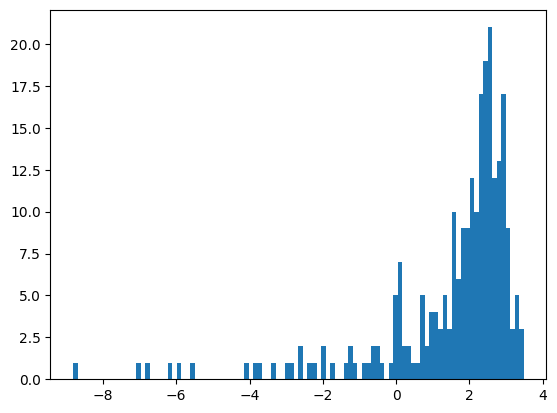

In [105]:
plt.hist(entropy,bins=100)
plt.show()

In [108]:
for name, param in model.named_parameters():
    print(name,param.shape)

fc1.weight torch.Size([250, 784])
fc1.bias torch.Size([250])
fc2.weight torch.Size([10, 250])
fc2.bias torch.Size([10])


In [116]:
import copy

node_lost = []
accuracy = []

for threshold in np.arange(-5,4,1):
    
    # Step0: Select neurons to prune
    selected_neurons = []
    for i in range(250):
        if entropy[i] < threshold:
            selected_neurons.append(i)

    # Make a copy of the original model
    copied_model = copy.deepcopy(model)

    # Step 1: Filter neurons
    for name, param in copied_model.named_parameters():
        if name == 'fc2.weight':  # Assuming 'fc1' is the layer you want to modify
            for neuron_index in selected_neurons:
                param.data[:,neuron_index] = 0  # Zero out the neuron
        if name == "fc1.weight":
            for neuron_index in selected_neurons:
                param.data[neuron_index] = 0

    # Step 2: Evaluate model on test data
    correct = 0
    total = 0
    copied_model.eval()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = copied_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy.append(100 * correct / total)
    node_lost.append(250 - len(selected_neurons))
            

    print(f"Accuracy of the model on the test data: {100 * correct / total}% for threshold: {threshold} with only {250 - len(selected_neurons)} neurons. ")

Accuracy of the model on the test data: 92.07% for threshold: -5 with only 244 neurons. 
Accuracy of the model on the test data: 91.9% for threshold: -4 with only 243 neurons. 
Accuracy of the model on the test data: 90.84% for threshold: -3 with only 240 neurons. 
Accuracy of the model on the test data: 88.78% for threshold: -2 with only 232 neurons. 
Accuracy of the model on the test data: 88.75% for threshold: -1 with only 227 neurons. 
Accuracy of the model on the test data: 87.53% for threshold: 0 with only 217 neurons. 
Accuracy of the model on the test data: 85.65% for threshold: 1 with only 191 neurons. 
Accuracy of the model on the test data: 77.46% for threshold: 2 with only 143 neurons. 
Accuracy of the model on the test data: 35.07% for threshold: 3 with only 19 neurons. 


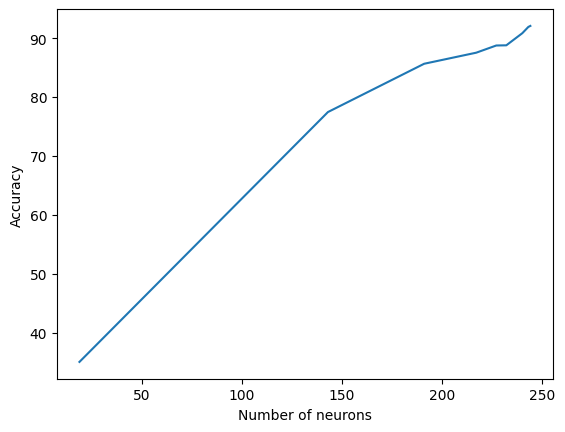

In [117]:
# Plot the accuracy vs number of neurons
plt.plot(node_lost,accuracy)
plt.xlabel("Number of neurons")
plt.ylabel("Accuracy")
plt.show()

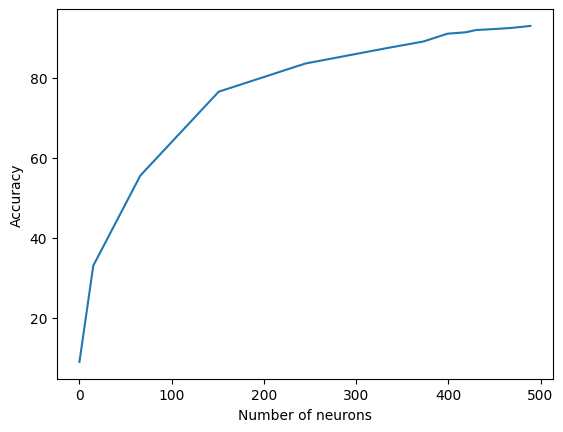

In [95]:
# Plot the accuracy vs number of neurons
plt.plot(node_lost,accuracy)
plt.xlabel("Number of neurons")
plt.ylabel("Accuracy")
plt.show()

In [105]:
# Assume `model` is your model and `input` is your input tensor
# Assume `optimizer` is the optimizer for your model
# Assume `criterion` is the loss function for your model

# Number of epochs
epochs = 1000
inputs = torch.rand(100, 1, 28, 28, requires_grad=True)


# Include `inputs` in the parameters that the optimizer is tracking
optimizer = torch.optim.SGD([ {'params': inputs}], lr=1)

# Then, in your training loop:
for epoch in range(epochs):
    # Forward pass
    output = model(inputs)
    
    target = torch.tensor([3]*100,dtype=torch.long)

    # Calculate the loss
    loss = criterion(output, target)

    # Backpropagate the loss
    loss.backward()

    # Update the weights AND inputs
    optimizer.step()
    
    # Get the gradients of the inputs
    input_gradients = inputs.grad

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Print loss for every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    #plt.imshow(inputs.detach().numpy().reshape(28,28),cmap='gray')
    #plt.show()
    
    

Epoch 1, Loss: 6.544097423553467
Epoch 2, Loss: 6.404799938201904
Epoch 3, Loss: 6.2662506103515625
Epoch 4, Loss: 6.128225326538086
Epoch 5, Loss: 5.99028205871582
Epoch 6, Loss: 5.8523030281066895
Epoch 7, Loss: 5.714568614959717
Epoch 8, Loss: 5.577173233032227
Epoch 9, Loss: 5.440344333648682
Epoch 10, Loss: 5.304072856903076
Epoch 11, Loss: 5.168038368225098
Epoch 12, Loss: 5.032655715942383
Epoch 13, Loss: 4.897667407989502
Epoch 14, Loss: 4.763254165649414
Epoch 15, Loss: 4.629744529724121
Epoch 16, Loss: 4.496885776519775
Epoch 17, Loss: 4.364274501800537
Epoch 18, Loss: 4.232733249664307
Epoch 19, Loss: 4.102503776550293
Epoch 20, Loss: 3.9737465381622314
Epoch 21, Loss: 3.8461825847625732
Epoch 22, Loss: 3.7198238372802734
Epoch 23, Loss: 3.594808578491211
Epoch 24, Loss: 3.4713099002838135
Epoch 25, Loss: 3.3495218753814697
Epoch 26, Loss: 3.2296764850616455
Epoch 27, Loss: 3.1116721630096436
Epoch 28, Loss: 2.995748281478882
Epoch 29, Loss: 2.882200002670288
Epoch 30, Loss:

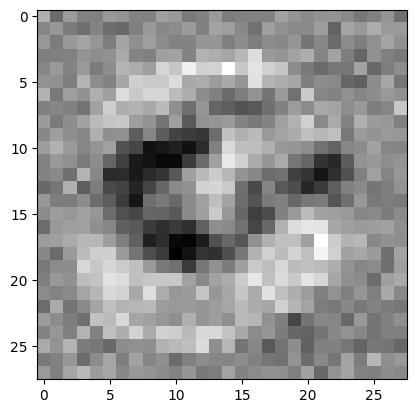

In [106]:
plt.imshow(inputs.mean(axis=0).detach().numpy().reshape(28,28),cmap='gray')
plt.show()

In [107]:
threshold = 0
activated_inputs = (input_gradients.mean(axis=0) > threshold).float()

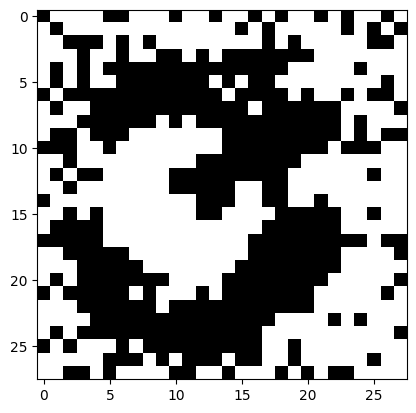

In [108]:
plt.imshow(activated_inputs[0],cmap='gray')